In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.datasets import load_digits, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from IPython.display import clear_output
import matplotlib.pylab as plt
import warnings

np.random.seed(42)

warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных - 

Загрузим простую версию MNIST(8 * 8) или MNIST (28*28)

In [2]:
#8 * 8
# digits= load_digits()
# mnist_data, mnist_labels = digits.data, digits.target

#28 * 28
mnist_data, mnist_labels = fetch_openml('mnist_784', version=1, return_X_y=True)
mnist_data = np.array(mnist_data)
mnist_labels = np.array(mnist_labels).astype(int)

In [3]:
print("Image Data Shape" ,mnist_data.shape)
print("Label Data Shape", mnist_labels.shape)

Image Data Shape (70000, 784)
Label Data Shape (70000,)


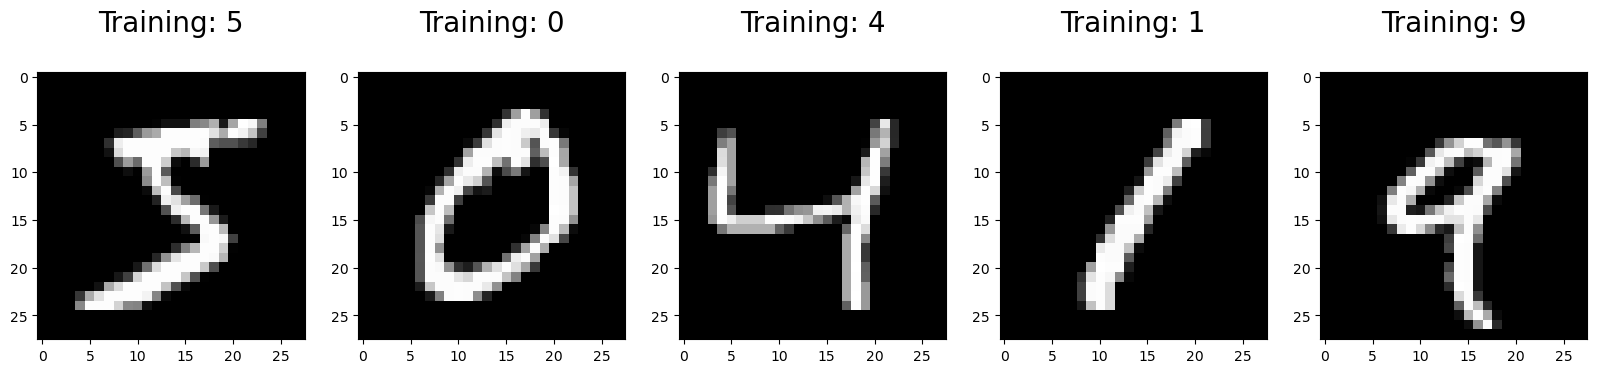

In [4]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(mnist_data[:5, :], mnist_labels[:5])):
    plt.subplot(1, 5, index + 1)
    image = np.array(image).reshape(28,28)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

Данные стоит нормализовать перед работой.

In [5]:
mnist_data = (mnist_data/255).astype('float32')

Разобьем нашу выборку на train, val, test.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(mnist_data, mnist_labels, test_size=0.25, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.25, random_state=0)

print(x_train.shape, x_val.shape, x_test.shape)

(52500, 784) (13125, 784) (4375, 784)


В задачах DL принято пользоваться потоковой подачей данных в модель(чтобы не тратить время на чтение датасета с диска) - поэтом реализуем класс BatchLoader с генератором, который будет быстро подавать данные в модель из RAM.

In [7]:
class BatchLoader:
  def __init__(self, data, target, batch_size):
    self.oh_encoder = OneHotEncoder()
    self.data = data
    self.target = self.oh_encoder.fit_transform(target.reshape(-1,1)).toarray()
    self.batch_size = batch_size
    self.idx = 0

  def __len__(self):
    batch_amount = self.data.shape[0] // self.batch_size
    if batch_amount * self.batch_size < len(self.data):
      batch_amount += 1
    return batch_amount

  def __call__(self):
    data_batch = self.data[self.idx: self.idx + self.batch_size, :]
    target_batch = self.target[self.idx: self.idx + self.batch_size, :]
    self.idx += self.batch_size
    if self.idx >= len(self.data):
      self.idx = 0
    return data_batch, target_batch

def test():
  batch_loader = BatchLoader(x_train, y_train, 16)
  x,y = batch_loader()
  print(x.shape, y.shape, len(batch_loader))


test()

(16, 784) (16, 10) 3282




*   Всегда фиксируйте seed перед экспериментами.
*   Bias не иниицализируют, инициализируют только веса.
*   Помните про SOLID при построении методов модели и не перегружайте класс сети. Не стоит писать полный цил обучения внутри методов класса, лучше вынести в отдельный модуль/функцию.








In [9]:

class NeuralNet:
  def __init__(self, input_size, hidden_size, output_size, lr):
    np.random.seed(42)
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.lr = lr
    #first layer
    self.w_1 = np.zeros((self.input_size, self.hidden_size))
    self.b_1 = np.zeros((1, self.hidden_size))
    #second layer
    self.w_2 = np.zeros((self.hidden_size, self.output_size))
    self.b_2 = np.zeros((1, self.output_size))
    #weights init
    self.initialize_weights()

  def get_weights(self):
    return {
        'w_1': self.w_1, 
        'b_1': self.b_1, 
        'w_2': self.w_2, 
        'b_2': self.b_2, 
    }

  def set_weights(self, weights_dict):
    self.w_1 = weights_dict['w_1']
    self.b_1 = weights_dict['b_1']
    self.w_2 = weights_dict['w_2']
    self.b_2 = weights_dict['b_2']


  def initialize_weights(self):
    #first layer
    self.w_1 = np.random.randn(*self.w_1.shape) * np.sqrt(1. / self.hidden_size)
    #second layer
    self.w_2 = np.random.randn(*self.w_2.shape) * np.sqrt(1. / self.output_size)

  def softmax(self, x):
    e_x = np.exp(x - np.max(x, axis=1).reshape(-1,1))
    softmax =  e_x / e_x.sum(axis=1).reshape(-1,1)
    return softmax


  def forward(self, X):
    self.Z_1 = np.dot(X, self.w_1) + self.b_1
    self.A_1 = np.maximum(0 , self.Z_1)
    self.Z_2 = np.dot(self.A_1, self.w_2) + self.b_2
    pred_distr = self.softmax(self.Z_2)
    return pred_distr

  def loss(self, y_pred, y_true):
    entropy_tensor = (y_true * np.log(y_pred)).sum(axis=1)
    loss = -np.mean(entropy_tensor)
    return loss

  def backward(self, X, y_pred, y_true):
    n_samples = y_true.shape[0]
    dZ_2 = y_pred - y_true

    dw_2 = 1/n_samples * np.dot(self.A_1.T, dZ_2)
    db_2 = 1/n_samples * (np.sum(dZ_2, axis=0, keepdims=True))
    
    dA_1 = np.dot(dZ_2, self.w_2.T)
    dZ_1 = np.multiply(dA_1, np.int64(self.Z_1 > 0))
    
    # не забываем делить градиенты на размер батча
    dw_1 = 1/n_samples * np.dot(X.T, dZ_1)
    db_1 = 1/n_samples * np.sum(dZ_1, axis=0, keepdims=True)

    gradient_dict = {'dw_1': dw_1, 'db_1': db_1, 'dw_2': dw_2, 'db_2': db_2}

    return gradient_dict

  def update_weights(self, gradient_dict):
    self.w_1 -= self.lr * gradient_dict['dw_1']
    self.b_1 -= self.lr * gradient_dict['db_1']
    
    self.w_2 -= self.lr * gradient_dict['dw_2']
    self.b_2 -= self.lr * gradient_dict['db_2']


def test():
  # общая проверерка работы forward & backward
  train_dataloader = BatchLoader(x_train, y_train, 2)
  X, y = train_dataloader()
  neural_net = NeuralNet(input_size=X.shape[1], 
                         hidden_size=15, 
                         output_size=y.shape[1], lr=0.1)
  predictions = neural_net.forward(X)
  loss = neural_net.loss(predictions, y)
  gradient_dict = neural_net.backward(X, predictions, y)
  neural_net.update_weights(gradient_dict)
  print(loss)

test()

4.812869250403987


### Gradient check

Построение backward - сложный алгоритм, можно легко ошибиться. Для проверки нашего решения проверим, как наше аналитическое нахождение градиента соотносится с численным. Для этого реализуем еще 2 функции - перевода из словаря весов в единый вектор параметров и обратно.

In [10]:
from collections import OrderedDict

def vector2dict(input_vector, initial_tensor_shapes_dict):
  slice_start_idx = 0
  result_dict = dict()
  for key in initial_tensor_shapes_dict:
    dim_1, dim_2 = initial_tensor_shapes_dict[key][0], initial_tensor_shapes_dict[key][1]
    slice_end_idx = slice_start_idx + (dim_1*dim_2)
    vector_slice = input_vector[slice_start_idx: slice_end_idx]
    matrix = vector_slice.reshape(dim_1, dim_2)
    result_dict[key] = matrix
    slice_start_idx = slice_end_idx
  return result_dict


def dict2vector(input_dict):
  key2shape_dict = OrderedDict()
  vector_list = []
  for key in input_dict:
    vector, shape  = input_dict[key].flatten(), input_dict[key].shape
    key2shape_dict[key] = shape
    vector_list.append(vector)
  result_vector = np.concatenate(vector_list, axis=0)
  return result_vector, key2shape_dict


def test():
  initial_dict = {
      'w_1': np.random.rand(2,3),
      'b_1': np.random.rand(1,3),
      'w_2': np.random.rand(3,2),
      'b_2': np.random.rand(1,2)
  }
  print(initial_dict)
  dict_vector, shape_dict = dict2vector(initial_dict)
  print(dict_vector)
  result_dict = vector2dict(dict_vector, shape_dict)
  for key in initial_dict:
    if (initial_dict[key] == result_dict[key]).all() == False:
      print('Dicts not equal!')
      return
  print('Dicts equal!')


test()

{'w_1': array([[0.18640541, 0.56050873, 0.86618892],
       [0.88280568, 0.06994401, 0.41910509]]), 'b_1': array([[0.58300648, 0.1470699 , 0.76543222]]), 'w_2': array([[0.74423526, 0.90334101],
       [0.00848601, 0.21668424],
       [0.82718671, 0.67058005]]), 'b_2': array([[0.89438985, 0.05717965]])}
[0.18640541 0.56050873 0.86618892 0.88280568 0.06994401 0.41910509
 0.58300648 0.1470699  0.76543222 0.74423526 0.90334101 0.00848601
 0.21668424 0.82718671 0.67058005 0.89438985 0.05717965]
Dicts equal!


In [11]:
def gradient_check(X, y, epsilon=1e-7):
  #получаем параметры модели
  neural_net = NeuralNet(input_size=X.shape[1], 
                         hidden_size=15, 
                         output_size=y.shape[1], lr=0.01)
  #преобразовываем словарь весов в вектор
  neural_net_params_dict = neural_net.get_weights()
  neural_net_params_vector, neural_net_params_shapes_dict = dict2vector(neural_net_params_dict)
  params_amount = neural_net_params_vector.shape[0]
  #инициализируем массив для рассчета численного градиента
  gradient_approx_vector = np.zeros((params_amount,))

  for i in range(params_amount):
    #рассчет J_plus для параметра i из neural_net_params_vector
    params_plus_vector = np.copy(neural_net_params_vector)
    # к параметру сети i прибавляем epsilon -> преобразуем вектор обратно в словарь -> инициализируем сеть с новым параметром
    params_plus_vector[i] += epsilon
    params_plus_dict = vector2dict(params_plus_vector, neural_net_params_shapes_dict)
    neural_net.set_weights(params_plus_dict)
    # рассчитываем J_plus
    y_plus = neural_net.forward(X)
    J_plus = neural_net.loss(y_plus, y)

    #рассчет J_minus для параметра i из neural_net_params_vector
    params_minus_vector = np.copy(neural_net_params_vector)
    # у параметра сети i вычитаем epsilon -> преобразуем вектор обратно в словарь -> инициализируем сеть с новым параметром
    params_minus_vector[i] -= epsilon
    params_minus_dict = vector2dict(params_minus_vector, neural_net_params_shapes_dict)
    neural_net.set_weights(params_minus_dict)
    # рассчитываем J_minus
    y_minus = neural_net.forward(X)
    J_minus = neural_net.loss(y_minus, y)
    # рассчитываем приближенного значение численного градиента для параметра i
    gradient_approx_vector[i] = (J_plus - J_minus) / (2 * epsilon)

  # возвратим исходное состояние весов для рассчета реализиованного градиента
  neural_net.set_weights(neural_net_params_dict)
  # посчитаем словарь градиентов
  y_pred = neural_net.forward(X)
  gradient_dict = neural_net.backward(X, y_pred, y)
  # превратим словарь в вектор
  gradient_vector, _ = dict2vector(gradient_dict)

  #рассчитаем итоговое значение
  print(np.linalg.norm(gradient_approx_vector), np.linalg.norm(gradient_vector))

  numerator = np.linalg.norm(gradient_approx_vector - gradient_vector)
  denominator = np.linalg.norm(gradient_approx_vector) + np.linalg.norm(gradient_vector)
  diff = numerator / denominator

  if diff > epsilon:
    print('Backprop is incorrect!')
  else:
    print('Backprop is correct!')
  return diff


batch_loader = BatchLoader(x_train, y_train, 16)
x, y = batch_loader()
gradient_check(x, y, 1e-7)

4.214614850976356 4.214614847477485
Backprop is correct!


1.0809590607356629e-08

In [12]:
def eval_acc(y_pred, y_true):
    pred_label = np.argmax(y_pred, axis=1)
    true_label = np.argmax(y_true, axis=1)
    accuracy = (pred_label == true_label).mean()
    return accuracy

def test():
  train_dataloader = BatchLoader(x_train, y_train, 4)
  data_b, target_b = train_dataloader()
  pred = np.random.rand(target_b.shape[0], target_b.shape[1])
  print(eval_acc(pred, target_b))

test()

0.0


#### Обучение модели

Обычно весь цикл обучения пишут в одном модуле, а ключевые компоненты выносят в методы класса нейронной сети и оптимизатора.

При обучении старайтесь визуализовать и логгировать процесс обучения - так проще дебажить.

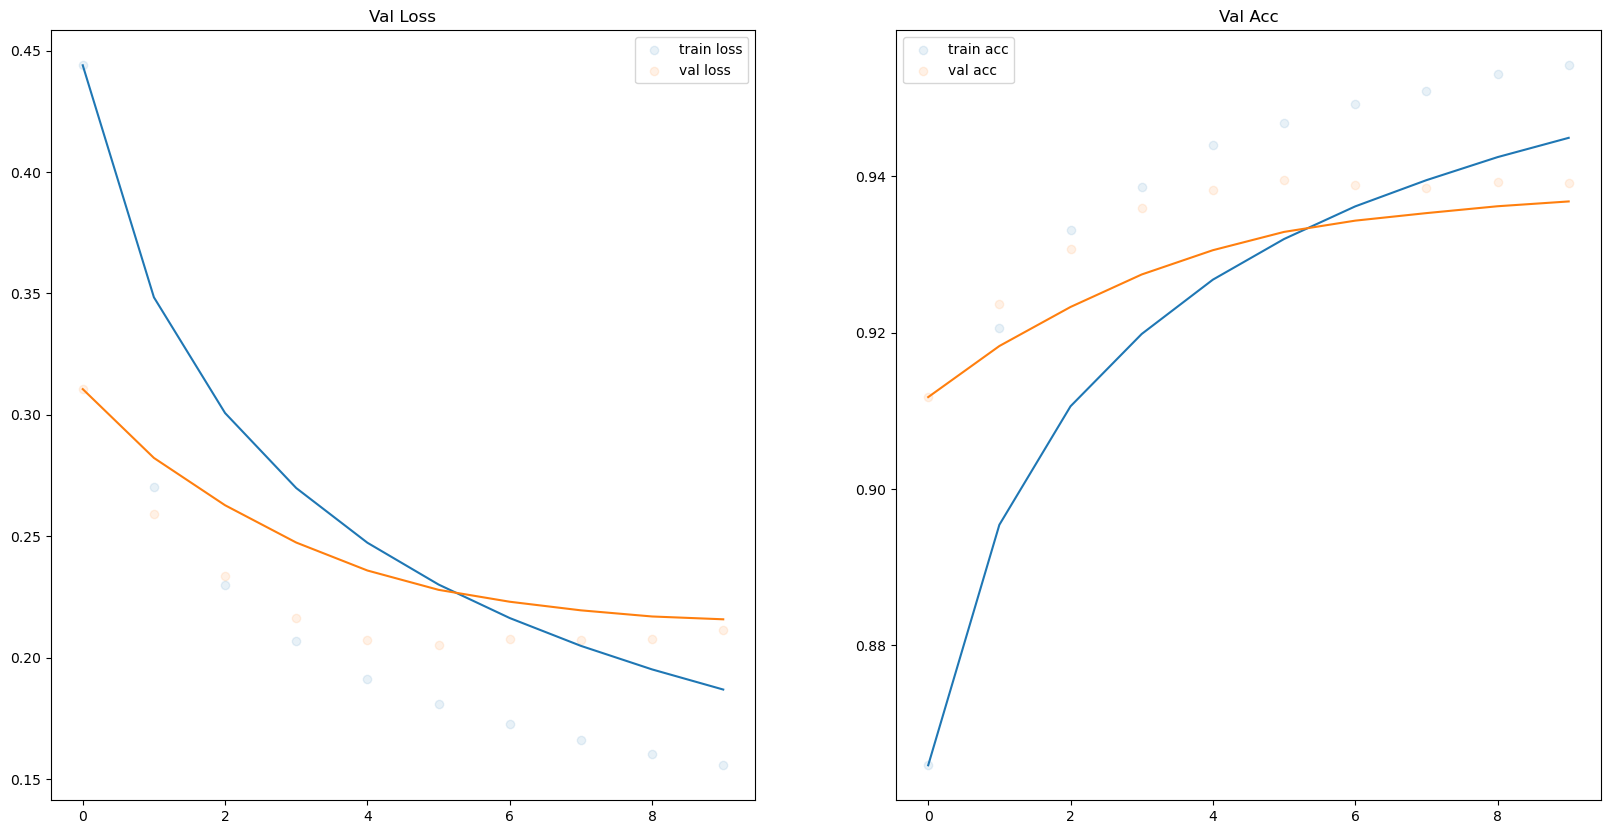

In [13]:
EPOCH_NUMBER = 10
BATCH_SIZE = 16
HIDDEN_SIZE = 16
LEARNING_RATE = 0.1

train_dataloader = BatchLoader(x_train, y_train, BATCH_SIZE)
val_dataloader = BatchLoader(x_val, y_val, BATCH_SIZE)

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

neural_net = NeuralNet(input_size=train_dataloader.data.shape[1], 
                         hidden_size=HIDDEN_SIZE, 
                         output_size=train_dataloader.target.shape[1], 
                       lr=LEARNING_RATE)


train_epoch_loss_array, train_epoch_acc_array = [], []
val_epoch_loss_array, val_epoch_acc_array = [], []

for epoch in range(EPOCH_NUMBER):
  train_epoch_loss, train_epoch_acc = 0, 0
  for _ in range(len(train_dataloader)):
    x_batch, y_batch = train_dataloader()
    # forward pass -> backward pass -> weights update 
    y_batch_pred = neural_net.forward(x_batch)
    train_batch_loss = neural_net.loss(y_batch_pred, y_batch)
    gradient_dict = neural_net.backward(x_batch, y_batch_pred, y_batch)
    neural_net.update_weights(gradient_dict)

    train_epoch_loss += train_batch_loss
    train_epoch_acc += eval_acc(y_batch_pred, y_batch)    

  train_epoch_loss_array.append(train_epoch_loss / len(train_dataloader))
  train_epoch_acc_array.append(train_epoch_acc / len(train_dataloader))

  val_epoch_loss, val_epoch_acc = 0, 0
  for _ in range(len(val_dataloader)):
    x_batch, y_batch = val_dataloader()
    y_batch_pred = neural_net.forward(x_batch)
    val_batch_loss = neural_net.loss(y_batch_pred, y_batch)

    val_epoch_loss += val_batch_loss
    val_epoch_acc += eval_acc(y_batch_pred, y_batch)
  val_epoch_loss_array.append(val_epoch_loss / len(val_dataloader))
  val_epoch_acc_array.append(val_epoch_acc / len(val_dataloader))


  clear_output(True)
  plt.figure(figsize=[20, 10])
  #plot train loss
  plt.subplot(1, 2, 1), plt.title('Train Loss'), plt.grid()
  plt.scatter(np.arange(len(train_epoch_loss_array)), train_epoch_loss_array, alpha=0.1, label='train loss')
  plt.plot(ewma(train_epoch_loss_array, span=10))
  plt.legend()
  #plot train acc
  plt.subplot(1, 2, 2), plt.title('Train Acc'), plt.grid()
  plt.scatter(np.arange(len(train_epoch_acc_array)), train_epoch_acc_array, alpha=0.1, label='train acc')
  plt.plot(ewma(train_epoch_acc_array, span=10))
  plt.legend()
  #plot val loss
  plt.subplot(1, 2, 1), plt.title('Val Loss'), plt.grid()
  plt.scatter(np.arange(len(val_epoch_loss_array)), val_epoch_loss_array, alpha=0.1, label='val loss')
  plt.plot(ewma(val_epoch_loss_array, span=10))
  plt.legend()
  #plot val acc
  plt.subplot(1, 2, 2), plt.title('Val Acc'), plt.grid()
  plt.scatter(np.arange(len(val_epoch_acc_array)), val_epoch_acc_array, alpha=0.1, label='val acc')
  plt.plot(ewma(val_epoch_acc_array, span=10))
  plt.legend()
  plt.show()

#### Валидация

Не забываем проверить качество работы модели.

In [14]:
test_dataloader = BatchLoader(x_test, y_test, BATCH_SIZE)

predictions_list = []
labels_list = []

for _ in range(len(test_dataloader)):
  y_batch_pred = neural_net.forward(x_batch)

  preds = np.argmax(y_batch_pred, axis=1)
  labels = np.argmax(y_batch, axis=1)

  predictions_list.append(preds)
  labels_list.append(labels)

prediction = np.concatenate(predictions_list)
label = np.concatenate(labels_list)

result = (prediction == label).mean()

print('Result: ', result)

Result:  0.8
